In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# # Para deixar os plots brancos
# params = {"ytick.color" : "w",
#           "xtick.color" : "w",
#           "axes.titlecolor" : "w",
#           "axes.labelcolor" : "w",
#           "axes.edgecolor" : "w"}
# plt.rcParams.update(params)

In [2]:
# ## Create an experiment with your api key
# experiment = Experiment(
#     api_key="Q5t8ZJ5IC5PvHbwAugI7xihW4",
#     project_name="mlp-pseudomeasurements",
#     workspace="kaioforte",
#     auto_histogram_weight_logging=True,
#     auto_histogram_gradient_logging=True,
#     auto_histogram_activation_logging=True,
# )

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.com/kaioforte/mlp-pseudomeasurements/77618269d9864d44945baec5b27c8048



In [2]:
net_result = np.load('dataset/MC_Simulation_std_025_samples_1000_01_09-21_19.npz')
# net_result = loadmat('dataset/resultados_w1000pts.mat')
ptrafo1 = pd.DataFrame(net_result['p_trafo1'], columns = ['Ptrafo1'])
ptrafo2 = pd.DataFrame(net_result['p_trafo2'], columns = ['Ptrafo2'])

demand_p = pd.DataFrame(net_result['demand_p'])
demand_p.columns = [f'P{col_name}' for col_name in demand_p.columns]
demand_p = demand_p.drop(['P0','P25'], axis=1)

demand_q = pd.DataFrame(net_result['demand_q'])
demand_q.columns = [f'Q{col_name}' for col_name in demand_q.columns]
demand_q = demand_q.drop(['Q0','Q25'], axis=1)

voltages = pd.DataFrame(net_result['voltages'])

vref1 = voltages.iloc[:, 0]
vref2 = voltages.iloc[:, 25]

In [3]:
## Creating a averageP/Q array of (144 x 42) by taking the mean value of all 1000 samples
## Repeating it 1000 times to match the 144000 samples of the cargaP/Q array
## Droping the 0th and 25th powers because this represents the transformer reference values
avgP = net_result['demand_p'].reshape(144,1000,42).mean(axis=1)
avgQ = net_result['demand_q'].reshape(144,1000,42).mean(axis=1)

avgP = pd.DataFrame(avgP)
avgP  = pd.concat([avgP]*1000, ignore_index=True)
avgP.columns = [f'P{col_name}' for col_name in avgP.columns]
avgP = avgP.drop(['P0','P25'], axis=1)

avgQ = pd.DataFrame(avgQ)
avgQ  = pd.concat([avgQ]*1000, ignore_index=True)
avgQ.columns = [f'Q{col_name}' for col_name in avgQ.columns]
avgQ = avgQ.drop(['Q0','Q25'], axis=1)

In [4]:
pv = np.load('dataset/PV_Curves_1000_Samples_01_09-23_31.npz')

pv_12 = pd.DataFrame(pv['PV_w'].flatten(), columns = ['pv_12'])
pv_18 = pd.DataFrame(pv['PV_w'].flatten(), columns = ['pv_18'])
pv_25 = pd.DataFrame(pv['PV_w'].flatten(), columns = ['pv_25'])
pv_29 = (1/47) * pd.DataFrame(pv['PV_w'].flatten(), columns = ['pv_29'])
pv_32 = (1/42) * pd.DataFrame(pv['PV_w'].flatten(), columns = ['pv_32'])

In [5]:
## Creating the input arrays for train and test
## X - train set 70%
## X_test - test set 30%

X = pd.concat([vref1, vref2, pv_12, pv_18, pv_25, pv_29, pv_32, ptrafo1, ptrafo2, avgP, avgQ], axis=1)
X.rename(columns = {0:'V0', 25:'V25'}, inplace = True)

# # Removing features that don't change
# features_to_drop = X.nunique()
# features_to_drop = features_to_drop.loc[features_to_drop.values==1].index

# X = X.drop(features_to_drop,axis=1)

X = X.iloc[43200:,:]
X_test = X.iloc[:43200,:]


In [6]:
voltage_columns = ['V0', 'V25']
active_power_columns = ['pv_12', 'pv_18', 'pv_25', 'pv_29', 'pv_32', 'Ptrafo1',
       'Ptrafo2', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10',
       'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20',
       'P21', 'P22', 'P23', 'P24', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31',
       'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'P38', 'P39', 'P40', 'P41']
reactive_power_columns = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11',
       'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21',
       'Q22', 'Q23', 'Q24', 'Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q31', 'Q32',
       'Q33', 'Q34', 'Q35', 'Q36', 'Q37', 'Q38', 'Q39', 'Q40', 'Q41']

In [7]:
## Creating the output arrays for train and test, and droping the reference(trafo) buses
## Y - train set
## y_test - test set
Y = voltages.drop([0,25], axis=1)
y_test = Y.iloc[:43200,:]
Y = Y.iloc[43200:,:]


In [8]:
from sklearn.model_selection import train_test_split

## Spliting the train dataset into train and validation data
X_train, X_eval, y_train, y_eval = train_test_split(X,Y,test_size=0.3,random_state=101)

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Scaling the input array
voltage_scaler = MinMaxScaler()
X_train.loc[:, voltage_columns] = voltage_scaler.fit_transform(X_train.loc[:, voltage_columns])
X_eval.loc[:, voltage_columns] = voltage_scaler.transform(X_eval.loc[:, voltage_columns])
X_test.loc[:, voltage_columns] = voltage_scaler.transform(X_test.loc[:, voltage_columns])

active_power_scaler = MinMaxScaler()
X_train.loc[:, active_power_columns] = active_power_scaler.fit_transform(X_train.loc[:, active_power_columns])
X_eval.loc[:, active_power_columns] = active_power_scaler.transform(X_eval.loc[:, active_power_columns])
X_test.loc[:, active_power_columns] = active_power_scaler.transform(X_test.loc[:, active_power_columns])

reactive_power_scaler = MinMaxScaler()
X_train.loc[:, reactive_power_columns] = reactive_power_scaler.fit_transform(X_train.loc[:, reactive_power_columns])
X_eval.loc[:, reactive_power_columns] = reactive_power_scaler.transform(X_eval.loc[:, reactive_power_columns])
X_test.loc[:, reactive_power_columns] = reactive_power_scaler.transform(X_test.loc[:, reactive_power_columns])


C:\Users\kaioh\AppData\Local\Temp\ipykernel_17108\2310833314.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.loc[:, voltage_columns] = voltage_scaler.transform(X_test.loc[:, voltage_columns])
C:\Users\kaioh\AppData\Local\Temp\ipykernel_17108\2310833314.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.loc[:, active_power_columns] = active_power_scaler.transform(X_test.loc[:, active_power_columns])
C:\Users\kaioh\AppData\Local\Temp\ipykernel_17108\2310833314.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam

batch_size = 70
epochs = 150

## Creating the model
model = Sequential()

model.add(Dense(units=200, activation='linear', input_shape=(X_train.shape[-1],)))
model.add(Dense(units=400, activation='linear'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=100, activation='linear'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=40, activation='relu'))

model.compile(optimizer=Adam(), loss='mse', metrics=['MAE'])

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping monitorando a Validation Loss
early_stopping = EarlyStopping(
    monitor="loss",
    min_delta = 0.0001, # Valor mínimo de mudança para considerar como melhoria
    patience  = 20,     # Quantas épocas esperar até parar
    mode = 'auto',
    restore_best_weights=True
)

In [12]:
history = model.fit(x=X_train,y=y_train,
        validation_data=(X_eval,y_eval),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping])

Epoch 1/150
1008/1008 [==============================] - 4s 3ms/step - loss: 0.0217 - MAE: 0.0994 - val_loss: 2.8715e-04 - val_MAE: 0.0136
Epoch 2/150
1008/1008 [==============================] - 9s 9ms/step - loss: 0.0030 - MAE: 0.0436 - val_loss: 1.0600e-04 - val_MAE: 0.0082
Epoch 3/150
1008/1008 [==============================] - 3s 3ms/step - loss: 0.0017 - MAE: 0.0329 - val_loss: 8.7704e-05 - val_MAE: 0.0075
Epoch 4/150
1008/1008 [==============================] - 3s 3ms/step - loss: 0.0010 - MAE: 0.0255 - val_loss: 3.7847e-05 - val_MAE: 0.0048
Epoch 5/150
1008/1008 [==============================] - 3s 3ms/step - loss: 5.8024e-04 - MAE: 0.0191 - val_loss: 6.9214e-05 - val_MAE: 0.0071
Epoch 6/150
1008/1008 [==============================] - 3s 3ms/step - loss: 2.8918e-04 - MAE: 0.0134 - val_loss: 1.3385e-05 - val_MAE: 0.0029
Epoch 7/150
1008/1008 [==============================] - 3s 3ms/step - loss: 1.1735e-04 - MAE: 0.0085 - val_loss: 5.4325e-06 - val_MAE: 0.0018
Epoch 8/150
100

In [22]:
len(logs)

30

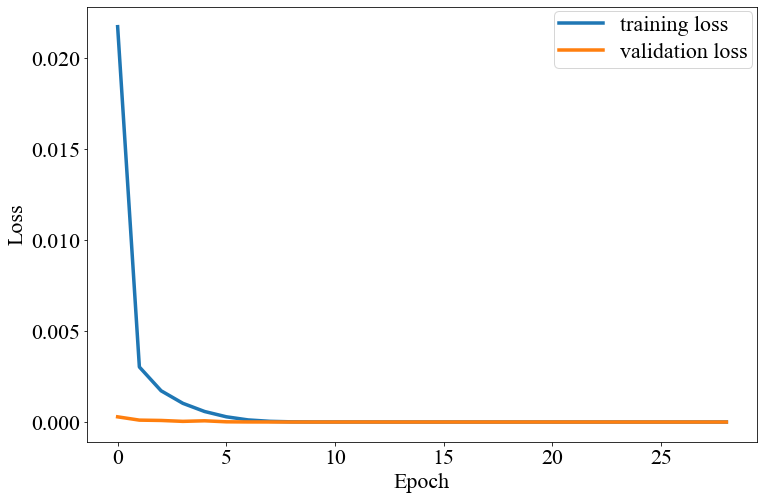

In [15]:
# Plot loss curve MAE curve
logs = pd.DataFrame(history.history)

plt.style.use('matplot.mplstyle')
plt.figure(figsize=(12, 8))
plt.plot(logs.loc[:,"loss"], label='training loss')
plt.plot(logs.loc[:,"val_loss"], label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.legend()
# plt.subplot(1, 2, 2)
# plt.plot(logs.loc[5:,"MAE"], label='training MAE')
# plt.plot(logs.loc[5:,"val_MAE"], label='validation MAE')
# plt.xlabel("Epoch")
# plt.ylabel("MAE")
plt.legend(loc='upper right')
plt.savefig(f"Loss_Curve.png")
plt.savefig(f"Loss_Curve.svg")
plt.show()

In [71]:
date = datetime.now().strftime('%d_%m-%H_%M')
model.save(f'70train_{batch_size}batch_{epochs}epochs_{date}.h5')

In [14]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

predictions = model.predict(X_test)

print(f"Mean Absolute Error: {mean_absolute_error(y_test.values,predictions)}")
print(f"Mean Squared Error: {np.sqrt(mean_squared_error(y_test.values,predictions))}")

Mean Absolute Error: 0.0017456656034583358
Mean Squared Error: 0.0028113165796953884


In [29]:
plt.style.use('matplot.mplstyle')

for i in [5,22,65,100,200]:
    for bar in [5,15,38]:
        t = np.arange(144)
        plt.figure(figsize = (13,6), dpi = 300)
        plt.plot(t,y_test.values[(i*144):((i*144)+144), bar], 'C1', lw = 3.5, label = 'Dataset')
        plt.plot(t,predictions[(i*144):((i*144)+144), bar], 'C0', lw = 2, label = 'Predictions')
        
        plt.xticks(np.arange(0, 145, 12), ('0h', '2h', '4h', '6h', '8h', '10h', '12h', '14h','16h', '18h', '20h', '22h', '24h'))
        plt.ylim(0.89, 1.07)
        plt.axhline(1.05, color="black", lw = 2, linestyle="--")
        plt.axhline(0.92, color="black", lw = 2, linestyle="--")
        plt.ylabel('p.u.')
        plt.title(f'Voltage Bar{bar} - Day {i} - With P/Q as Input', fontsize=22)
        plt.legend(loc='upper right', framealpha=1)
        plt.savefig(f"Voltage_Bar{bar}_Day{i}_PQ-025.jpg")
        plt.tight_layout()
        plt.margins(x=0)
        plt.grid(True)
        plt.close()

In [40]:
### Testing the model in a dataset with more variance

net_result = np.load('dataset/MC_Simulation_std_05_samples_1000_01_09-22_34.npz')
# net_result = loadmat('dataset/resultados_w1000pts.mat')
ptrafo1 = pd.DataFrame(net_result['p_trafo1'], columns = ['Ptrafo1'])
ptrafo2 = pd.DataFrame(net_result['p_trafo2'], columns = ['Ptrafo2'])

demand_p = pd.DataFrame(net_result['demand_p'])
demand_p.columns = [f'P{col_name}' for col_name in demand_p.columns]
demand_p = demand_p.drop(['P0','P25'], axis=1)

demand_q = pd.DataFrame(net_result['demand_q'])
demand_q.columns = [f'Q{col_name}' for col_name in demand_q.columns]
demand_q = demand_q.drop(['Q0','Q25'], axis=1)

voltages = pd.DataFrame(net_result['voltages'])

vref1 = voltages.iloc[:, 0]
vref2 = voltages.iloc[:, 25]

voltages.shape

(144000, 42)

In [44]:
## Creating a averageP/Q array of (144 x 42) by taking the mean value of all 1000 samples
## Repeating it 1000 times to match the 144000 samples of the cargaP/Q array
## Droping the 0th and 25th powers because this represents the transformer reference values
avgP = net_result['demand_p'].reshape(144,1000,42).mean(axis=1)
avgQ = net_result['demand_q'].reshape(144,1000,42).mean(axis=1)

avgP = pd.DataFrame(avgP)
avgP  = pd.concat([avgP]*1000, ignore_index=True)
avgP.columns = [f'P{col_name}' for col_name in avgP.columns]
avgP = avgP.drop(['P0','P25'], axis=1)

avgQ = pd.DataFrame(avgQ)
avgQ  = pd.concat([avgQ]*1000, ignore_index=True)
avgQ.columns = [f'Q{col_name}' for col_name in avgQ.columns]
avgQ = avgQ.drop(['Q0','Q25'], axis=1)

pv = np.load('dataset/PV_Curves_1000_Samples_01_09-23_31.npz')

pv_12 = pd.DataFrame(pv['PV_w'].flatten(), columns = ['pv_12'])
pv_18 = pd.DataFrame(pv['PV_w'].flatten(), columns = ['pv_18'])
pv_25 = pd.DataFrame(pv['PV_w'].flatten(), columns = ['pv_25'])
pv_29 = (1/47) * pd.DataFrame(pv['PV_w'].flatten(), columns = ['pv_29'])
pv_32 = (1/42) * pd.DataFrame(pv['PV_w'].flatten(), columns = ['pv_32'])
## Creating the input arrays for train and test
## X - train set 70%
## X_test - test set 30%

X = pd.concat([vref1, vref2, pv_12, pv_18, pv_25, pv_29, pv_32, ptrafo1, ptrafo2, avgP, avgQ], axis=1)
X.rename(columns = {0:'V0', 25:'V25'}, inplace = True)

## Creating the output arrays for train and test, and droping the reference(trafo) buses
## Y - train set
## y_test - test set

Y = voltages.drop([0,25], axis=1)

## Spliting the train dataset into train and validation data
X_train, X_eval, y_train, y_eval = train_test_split(X,Y,test_size=0.5,random_state=202)

## Scaling the input array
voltage_scaler = MinMaxScaler()
X_train.loc[:, voltage_columns] = voltage_scaler.fit_transform(X_train.loc[:, voltage_columns])
X_eval.loc[:, voltage_columns] = voltage_scaler.transform(X_eval.loc[:, voltage_columns])

active_power_scaler = MinMaxScaler()
X_train.loc[:, active_power_columns] = active_power_scaler.fit_transform(X_train.loc[:, active_power_columns])
X_eval.loc[:, active_power_columns] = active_power_scaler.transform(X_eval.loc[:, active_power_columns])

reactive_power_scaler = MinMaxScaler()
X_train.loc[:, reactive_power_columns] = reactive_power_scaler.fit_transform(X_train.loc[:, reactive_power_columns])
X_eval.loc[:, reactive_power_columns] = reactive_power_scaler.transform(X_eval.loc[:, reactive_power_columns])


In [47]:
from tensorflow.keras.models import load_model
new_model = load_model(r'70train_70batch_150epochs_19_10-01_48.h5')

predictions = new_model.predict(X_train)

print(f"Mean Absolute Error: {mean_absolute_error(y_train.values,predictions)}")
print(f"Mean Squared Error: {np.sqrt(mean_squared_error(y_train.values,predictions))}")

Mean Absolute Error: 0.0029046361182877047
Mean Squared Error: 0.004494268782466886


In [48]:
plt.style.use('matplot.mplstyle')

for i in [5,22,65,100,200]:
    for bar in [5,15,38]:
        t = np.arange(144)
        plt.figure(figsize = (13,6), dpi = 300)
        plt.plot(t,y_train.values[(i*144):((i*144)+144), bar], 'C1', lw = 3.5, label = 'Dataset')
        plt.plot(t,predictions[(i*144):((i*144)+144), bar], 'C0', lw = 2, label = 'Predictions')
        
        plt.xticks(np.arange(0, 145, 12), ('0h', '2h', '4h', '6h', '8h', '10h', '12h', '14h','16h', '18h', '20h', '22h', '24h'))
        plt.ylim(0.89, 1.07)
        plt.axhline(1.05, color="black", lw = 2, linestyle="--")
        plt.axhline(0.92, color="black", lw = 2, linestyle="--")
        plt.ylabel('p.u.')
        plt.title(f'Voltage Bar{bar} - Day {i} - With P/Q as Input', fontsize=22)
        plt.legend(loc='upper right', framealpha=1)
        plt.savefig(f"05_Prediction_Voltage_Bar{bar}_Day{i}_PQ.jpg")
        plt.tight_layout()
        plt.margins(x=0)
        plt.grid(True)
        plt.close()